In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import documents as docs
import textcomparisons as tc
import random
import time

start = time.time()

data_folder = "data"
article_files = ["articles2019-06-01_" + str(i) + "-" + str(i + 5000) + ".csv" for i in range(0, 100000, 5000)]
article_files = article_files + ["articles2019-06-01_100000-100755.csv"]

def readArticles(path):
    """ Reads df of articles from the given path, and adds a column
    to store the Document-processed article """
    article_df = pd.read_csv(path)
    article_df["doc"] = None
    return article_df

keywords = ["subscription", "subscribe", "full access", "digital access", "sign up", "unlimited access", 
            "unlimited digital access", "log in", "login", "sign up", "create an account", 
            "never miss a story", "for your first month", "to continue reading", "already a member",
            "rely on advertising", "click to continue"]

def keywordsin(str):
    for word in keywords:
        if word in str:
            return True
    return False

def isPaywall(i, to_doc = True):
    text = article_df.loc[i, "text"]
    text = text.lower()
    if len(text) < 500:
        article_df.loc[i, "paywall"] += 0.5
    if len(text) < 1000 and keywordsin(text):
        article_df.loc[i, "paywall"] += 1
    if to_doc and article_df.loc[i, "doc"] is None:
        article_df.loc[i, "doc"] = docs.Document(text, clean = False)
    return article_df.loc[i, "paywall"] > 0

def dict_by_ids(df, ids):
    """ Given a dataframe of articles and a list of article ids, 
    returns a dictionary with ids as keys and Documents as items, 
    computing and storing the Documents back in the df as needed
    """
    doc_dict = {}
    for doc_id in ids:
        row = df["id"] == doc_id
        doc = df.loc[row, "doc"].iloc[0]
        if doc is None:
            doc = docs.Document(df.loc[row, "text"].iloc[0], clean = False)
            df.loc[row, "doc"] = doc
        doc_dict[doc_id] = doc
    return doc_dict

def subsetmat(mat, inds):
    ''' Returns subset matrix of symmetric matrix mat, using inds
    '''
    subset = np.zeros((len(inds), len(inds)))
    for i in range(len(inds)):
        for j in range(len(inds)):
            subset[i, j] = mat[inds[i], inds[j]]
    return subset

try:
    article_df = pd.read_pickle("article_df_20190601")
except:
    article_df = [readArticles(os.path.join(data_folder, file)) for file in article_files]
    article_df = pd.concat(article_df)
    article_df = article_df.reset_index(drop = True)

    article_df["paywall"] = 0

events = [event for event in np.unique(article_df["event"]) if not np.isnan(event)]
n = [len(article_df.loc[article_df["event"] == event]) for event in events]
print("Event sizes: ", n)

try:
    results_df = pd.read_csv("results_20190601_clusters_temp.csv")
except: 
    results_df = pd.DataFrame(list(zip(events, n)), columns = ["event", "n"])
    results_df["unique25"] = np.nan
    results_df["unique75"] = np.nan
    results_df["n_good"] = np.nan
    results_df["unique25_good"] = np.nan
    results_df["unique75_good"] = np.nan

ac = tc.ArticleComparisons(thresh_jaccard = .5, thresh_same_sent = .9, thresh_same_doc = .25)
print("Setup time: %d seconds" % np.round(time.time() - start))

Event sizes:  [3175, 7333, 3280, 790, 750, 479, 1267, 2399, 269, 464, 187, 543, 580, 272, 1027, 377, 286, 391, 997, 269, 907, 272, 287, 351, 131, 333, 275, 503, 1067, 135, 691, 225, 123, 241, 263, 108, 140, 70, 239, 365, 172, 79, 244, 68, 68, 54, 69, 172, 172, 165]
Setup time: 12 seconds


In [19]:
i = 33
sample = np.array(article_df.loc[article_df["event"] == events[i], "id"])
article_dict = dict_by_ids(article_df, sample)
good_inds = [i for i in range(len(sample)) if not isPaywall(sample[i])]
results_df.loc[i, "n_good"] = len(good_inds)
print(len(good_inds))

237


In [20]:
clustering = ac.cluster_articles(article_dict, plot = False)
results_df.loc[i, "unique25"] = ac.prop_unique_clusters(thresh_same_doc = 0.25)
results_df.loc[i, "unique25_good"] = ac.prop_unique_clusters(thresh_same_doc = 0.25, inds = good_inds)
results_df.loc[i, "unique75"] = ac.prop_unique_clusters(thresh_same_doc = 0.75)
results_df.loc[i, "unique75_good"] = ac.prop_unique_clusters(thresh_same_doc = 0.75, inds = good_inds)
results_df.iloc[i, :]

0 / 241 done, 0.0 seconds elapsed
121 / 241 done, 1035.02 seconds elapsed
145 / 241 done, 1285.03 seconds elapsed
169 / 241 done, 1547.57 seconds elapsed
193 / 241 done, 1699.67 seconds elapsed
217 / 241 done, 1794.42 seconds elapsed


event             48.000000
n                241.000000
unique25           0.128631
unique75           0.207469
n_good           237.000000
unique25_good      0.122363
unique75_good      0.194093
Name: 33, dtype: float64

In [21]:
bad_ids = [i for i in sample if isPaywall(i)]
good_ids = [i for i in sample if i not in bad_ids]
for i in bad_ids:
    print(i, "\n", article_dict[i], "\n")
bad_inds = [i for i in range(len(sample)) if i not in good_inds]
ac.prop_unique_clusters(inds = bad_inds)
# ac.display_mat(jsm_b, xlabs = bad_inds)

7650 
 Deegan continues to shine as she races up NASCAR ladder 
 Get the top news stories delivered directly to your inbox! 
 Go 

13994 
 NASCAR XFINITY Series: Pocono Green 250 FS1 
 The Pocono Green 250 from Pocono Raceway in Long Pond, Pa. Points leader and reigning series champ Tyler Reddick (No. 2 car) won his second race of 2019 last week in Charlotte. He enters the "Tricky Triangle" with nine Top-5s in 11 starts this year. 
 Sat Jun 8 1:30pm 
 The LTi Printing 250 from Michigan International Speedway in Brooklyn, Mich. 
 Sat Jun 15 3:00pm 

17585 
 Ag community meets with Rep. Johnson during roundtable 
 Posted: May 31, 2019 10:09 PM CDT 
 Updated: May 31, 2019 10:09 PM CDT 
 . 
 Record weather in KELOLAND 
 Latest News - Local 
 Copyright 2019 Nexstar Broadcasting, Inc. All rights reserved. This material may not be published, broadcast, rewritten, or redistributed. 

81079 
 NASCAR rolls into Pocono this weekend 
 Pocono 400 on Sunday 
 Posted: May 31, 2019 08:18 PM EDT 
 Upda

1.0

In [22]:
ac.prop_unique_clusters()

0.2074688796680498

0 / 237 done, 0.0 seconds elapsed
24 / 237 done, 389.28 seconds elapsed
95 / 237 done, 955.78 seconds elapsed
166 / 237 done, 1330.46 seconds elapsed
190 / 237 done, 1405.01 seconds elapsed
0.1940928270042194


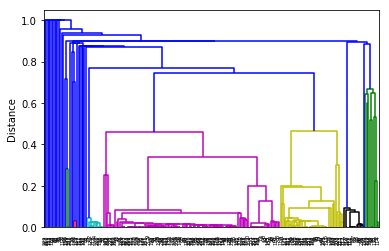

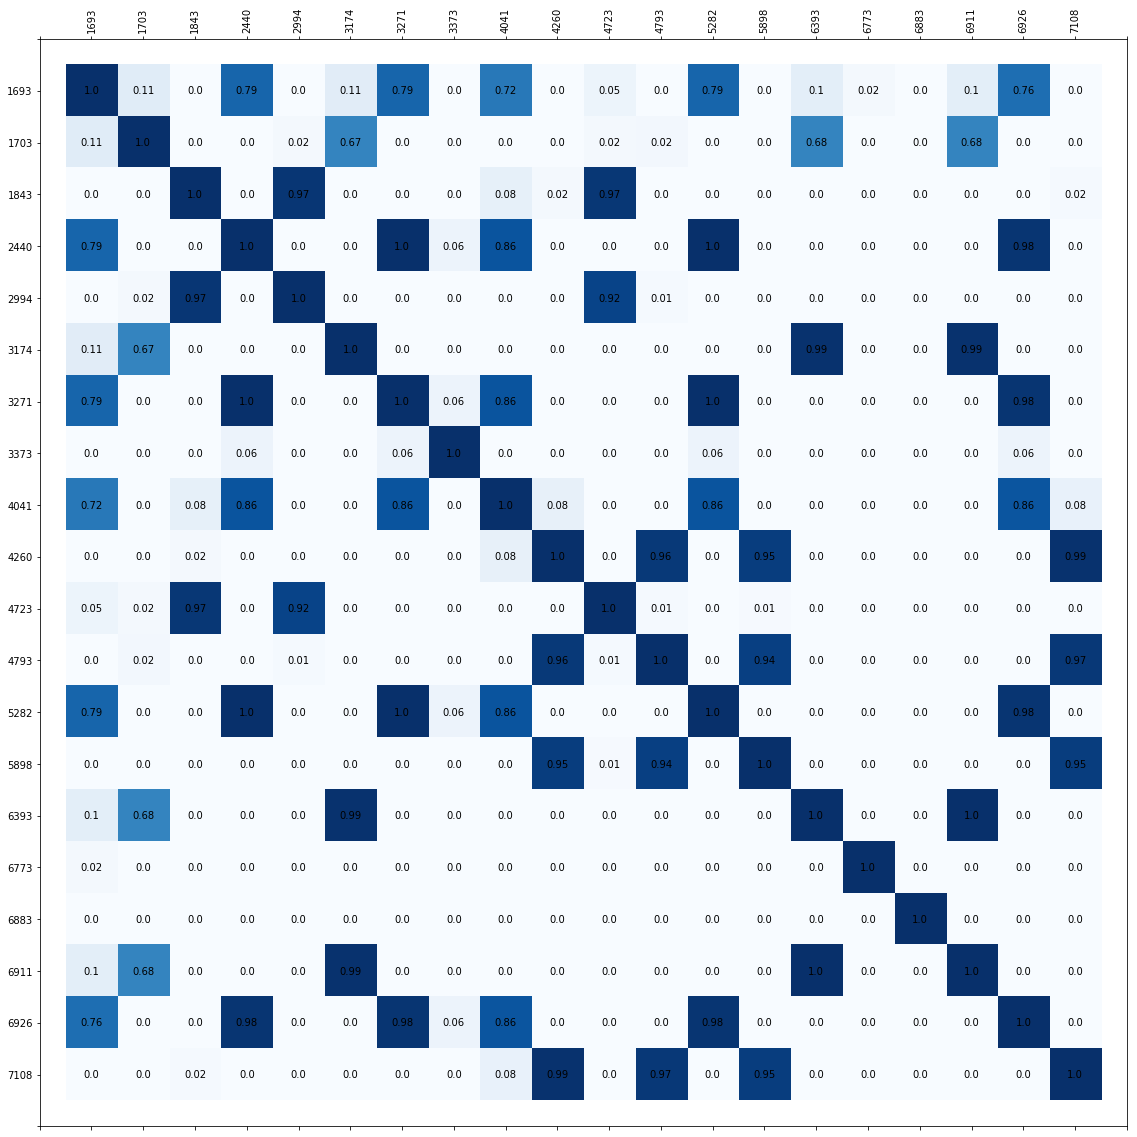

In [23]:
article_dict_subset = dict_by_ids(article_df, good_ids)
jsm = ac.jac_score_mat(article_dict_subset)
hc = ac.cluster_articles(plot = True)
print(ac.prop_unique_clusters())
# ac.display_mat(jsm, xlabs = list(article_dict.keys()))
n_subset = 20
ac.display_mat(subsetmat(jsm, list(range(n_subset))), xlabs = list(article_dict_subset.keys())[0:n_subset])

Good articles: 1703 True 6393 True
S 9 : Updated: June 1, 2019 @ 8:22 pm 
 419-636-1111 | news@bryantimes.com | 127 S. Walnut St., Bryan, OH 43506 
 Toggle navigation 
 DETROIT (AP) — The Latest on the Detroit Grand Prix (all times local): 
 6:25 p.m. 
 Josef Newgarden has won the first of two Detroit Grand Prix races, outlasting the competition Saturday on a rain-slicked road course. 

	T 1 0.54 : (AP Photo/Carlos Osorio) 
 DETROIT (AP) — The Latest on the Detroit Grand Prix (all times local): 
 6:25 p.m. 
 Josef Newgarden has won the first of two Detroit Grand Prix races, outlasting the competition Saturday on a rain-slicked road course. 

S 10 : The Team Penske driver finished nearly a second in front of Alexander Rossi, who also was the runner-up at the Indianapolis 500, and Takuma Sato. 

	T 2 1.0 : The Team Penske driver finished nearly a second in front of Alexander Rossi, who also was the runner-up at the Indianapolis 500, and Takuma Sato. 

S 11 : Newgarden, who opened the yea

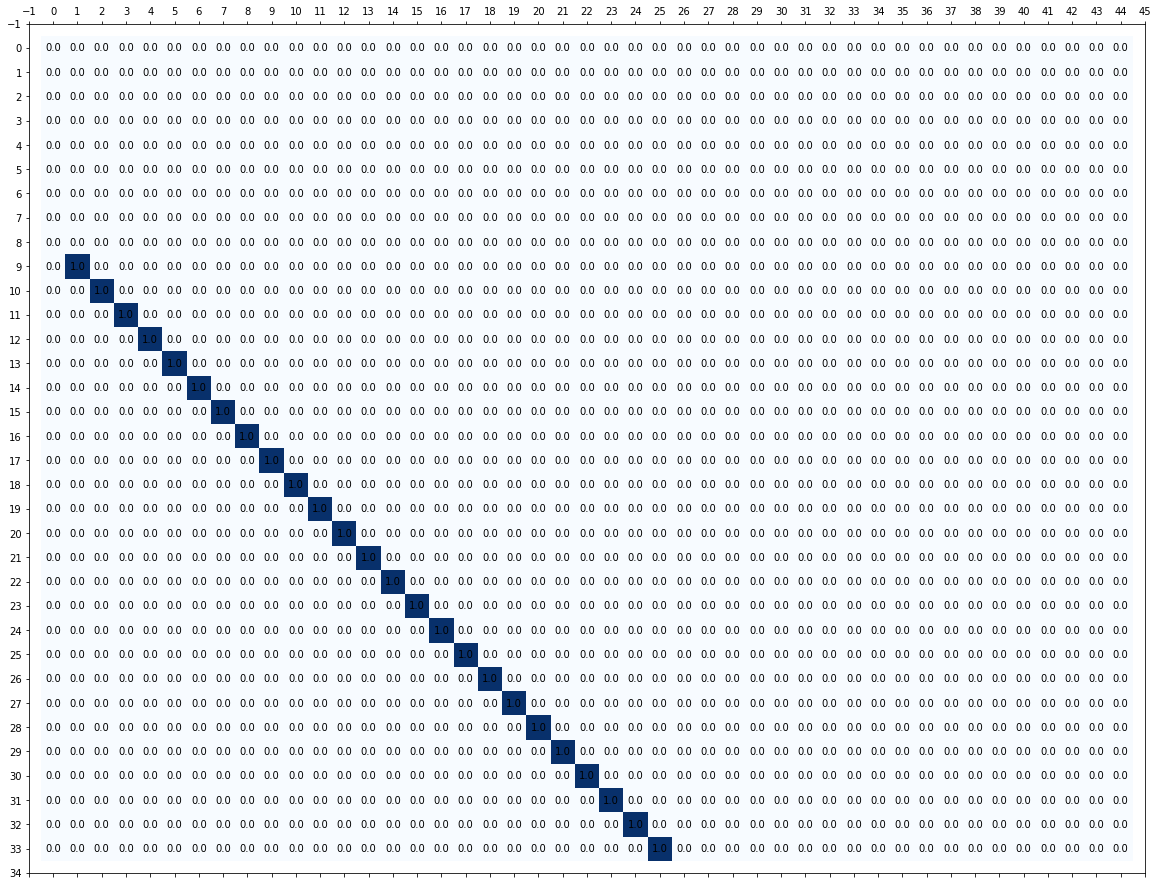

In [24]:
id1 = 1703
id2 = 6393
print("Good articles: %d" % id1, id1 in good_ids, id2, id2 in good_ids)
ac.display_mat(ac.get_match_matrix(article_dict[id1], article_dict[id2]))
ac.print_sentence_matches()

In [25]:
print(article_dict[id1])

Thank you for Reading! 
 Please log in, or sign up for a new account and purchase a subscription to continue reading. 
 (43506) 
 Today 
 Variable clouds with thunderstorms, especially early. A few storms may be severe. Low 58F. Winds W at 5 to 10 mph. Chance of rain 60%.. 
 Tonight 
 Variable clouds with thunderstorms, especially early. A few storms may be severe. Low 58F. Winds W at 5 to 10 mph. Chance of rain 60%. 
 Updated: June 1, 2019 @ 8:22 pm 
 (43506) 
 Today 
 Variable clouds with thunderstorms, especially early. A few storms may be severe. Low 58F. Winds W at 5 to 10 mph. Chance of rain 60%.. 
 Tonight 
 Variable clouds with thunderstorms, especially early. A few storms may be severe. Low 58F. Winds W at 5 to 10 mph. Chance of rain 60%. 
 Updated: June 1, 2019 @ 8:22 pm 
 419-636-1111 | news@bryantimes.com | 127 S. Walnut St., Bryan, OH 43506 
 Toggle navigation 
 DETROIT (AP) — The Latest on the Detroit Grand Prix (all times local): 
 6:25 p.m. 
 Josef Newgarden has won the

In [27]:
print(article_dict[id2].get_sentences())

['Copy link \n Related Topics \n The Latest: Newgarden wins 1st of 2 Detroit Grand Prix races \n - 18 minutes ago \n Josef Newgarden takes the 10th turn during the first race of the IndyCar Detroit Grand Prix auto racing doubleheader, Saturday, June 1, 2019, in Detroit.', '(AP Photo/Carlos Osorio) \n DETROIT (AP) — The Latest on the Detroit Grand Prix (all times local): \n 6:25 p.m. \n Josef Newgarden has won the first of two Detroit Grand Prix races, outlasting the competition Saturday on a rain-slicked road course.', 'The Team Penske driver finished nearly a second in front of Alexander Rossi, who also was the runner-up at the Indianapolis 500, and Takuma Sato.', "Newgarden, who opened the year with a victory at St. Petersburg, joins Indy 500 champion Simon Pagenaud as the series' two-time winners this season.", 'Newgarden has won 12 IndyCar races since 2015.', 'Pagenaud finished sixth after starting 13th in the 22-car field on Belle Isle.', 'The 70-lap race became a 75-minute timed 